<a href="https://colab.research.google.com/github/Omega-84/DCV-Transfer-Learning/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline 

In [ ]:
#Downloading the dataset
(raw_train,raw_test), metadata = tfds.load(
    'cifar10',
    split=['train[:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteAR7OOA/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteAR7OOA/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
def format_example(image, label):
    """
    returns an image that is reshaped to IMG_SIZE
    """
    IMG_SIZE = 224
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [ ]:
train = raw_train.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
def create_model():
    #A basic convolutional model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(10))
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])   
    return model

model_2 = create_model()

print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 173056)           

In [ ]:
network_2 = model_2.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,batch_size=10)

Epoch 1/10
1407/1407 [==============================] - 154s 109ms/step - loss: 0.4240 - accuracy: 0.8510 - val_loss: 1.9723 - val_accuracy: 0.5600
Epoch 2/10
1407/1407 [==============================] - 151s 107ms/step - loss: 0.2526 - accuracy: 0.9130 - val_loss: 2.3788 - val_accuracy: 0.5592
Epoch 3/10
1407/1407 [==============================] - 151s 107ms/step - loss: 0.1697 - accuracy: 0.9406 - val_loss: 2.8688 - val_accuracy: 0.5468
Epoch 4/10
1407/1407 [==============================] - 152s 108ms/step - loss: 0.1346 - accuracy: 0.9541 - val_loss: 3.1385 - val_accuracy: 0.5606
Epoch 5/10
1407/1407 [==============================] - 151s 107ms/step - loss: 0.1062 - accuracy: 0.9646 - val_loss: 3.4754 - val_accuracy: 0.5460
Epoch 6/10
1407/1407 [==============================] - 152s 108ms/step - loss: 0.0954 - accuracy: 0.9691 - val_loss: 3.8811 - val_accuracy: 0.5420
Epoch 7/10
1407/1407 [==============================] - 151s 107ms/step - loss: 0.0904 - accuracy: 0.9701 - val_

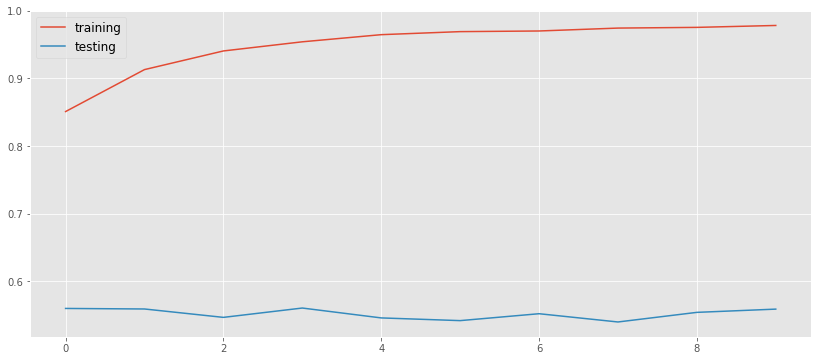

In [ ]:
plt.subplots(figsize=(14,6))
plt.plot(network_2.history['accuracy'],label='training')
plt.plot(network_2.history['val_accuracy'],label='testing')
plt.legend(loc='best',fontsize=12);

###Model is extremely overfit

# Transfer learning

##**Trying VGG16 first**

In [ ]:
IMAGE_SIZE = [224, 224]
base_model = tf.keras.applications.VGG16(input_shape=IMAGE_SIZE + [3],
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for image, _ in train_batches.take(1):
    pass

feature_batch = base_model(image)
print(feature_batch.shape)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = tf.keras.layers.Dense(10)

for augmentation
tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),

In [ ]:
model = tf.keras.Sequential([
    
    base_model,
    tf.keras.layers.Dropout(0.2),
    global_average_layer,
    prediction_layer
])

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

In [ ]:
network = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,callbacks = [early_stopping])

Epoch 1/10
1407/1407 [==============================] - 409s 277ms/step - loss: 1.6104 - accuracy: 0.4991 - val_loss: 1.3350 - val_accuracy: 0.5742
Epoch 2/10
1407/1407 [==============================] - 381s 270ms/step - loss: 1.2516 - accuracy: 0.5928 - val_loss: 1.1745 - val_accuracy: 0.6218
Epoch 3/10
1407/1407 [==============================] - 381s 270ms/step - loss: 1.1372 - accuracy: 0.6273 - val_loss: 1.0895 - val_accuracy: 0.6448
Epoch 4/10
1407/1407 [==============================] - 380s 270ms/step - loss: 1.0685 - accuracy: 0.6494 - val_loss: 1.0430 - val_accuracy: 0.6576
Epoch 5/10
1407/1407 [==============================] - 381s 271ms/step - loss: 1.0246 - accuracy: 0.6610 - val_loss: 1.0013 - val_accuracy: 0.6700
Epoch 6/10
1407/1407 [==============================] - 381s 270ms/step - loss: 0.9899 - accuracy: 0.6729 - val_loss: 0.9732 - val_accuracy: 0.6786
Epoch 7/10
1407/1407 [==============================] - 380s 270ms/step - loss: 0.9620 - accuracy: 0.6815 - val_

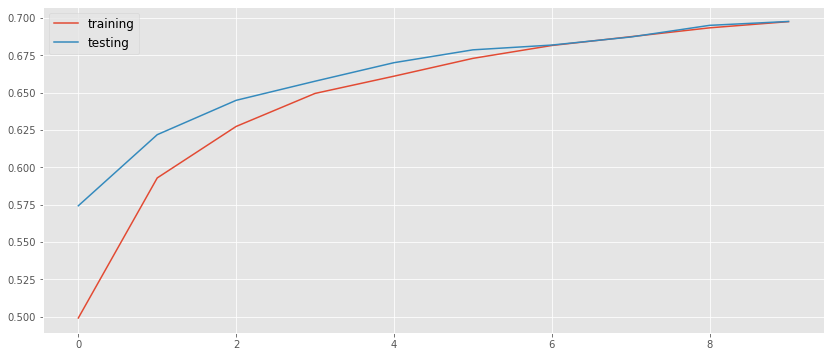

In [ ]:
plt.subplots(figsize=(14,6))
plt.plot(network.history['accuracy'],label='training')
plt.plot(network.history['val_accuracy'],label='testing')
plt.legend(loc='best',fontsize=12);

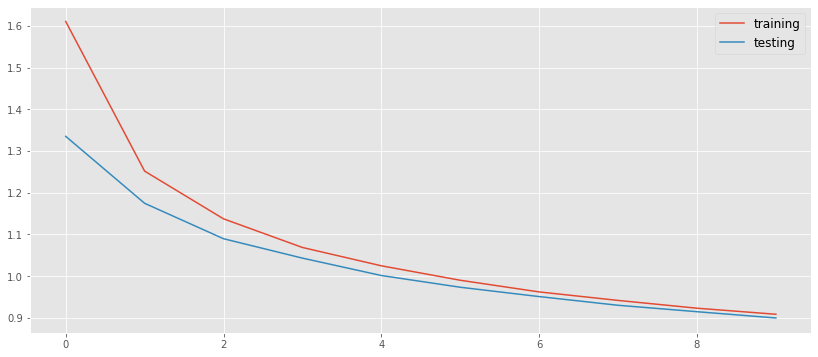

In [ ]:
plt.subplots(figsize=(14,6))
plt.plot(network.history['loss'],label='training')
plt.plot(network.history['val_loss'],label='testing')
plt.legend(loc='best',fontsize=12);

## Performs better than basic model

##**Trying MobileNet now**

In [ ]:
IMAGE_SIZE_2 = [160, 160]
base_model_2 = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE_2 + [3],
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model_2.trainable = False

In [ ]:
def format_example_2(image, label):
    """
    returns an image that is reshaped to IMG_SIZE
    """
    IMG_SIZE = 160
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [ ]:
train = raw_train.map(format_example_2)
test = raw_test.map(format_example_2)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
image_batch, label_batch = next(iter(train_batches))
feature_batch = base_model_2(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [ ]:
model_3 = tf.keras.Sequential([
                               tf.keras.Input(shape=(160, 160, 3)),
                               tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                               tf.keras.layers.RandomRotation(0.2),
                               base_model_2,
                               global_average_layer,
                               prediction_layer
])

In [ ]:
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [ ]:
network_3 = model_3.fit(train_batches,
                      epochs=10,
                      validation_data=test_batches,
                      callbacks = [early_stopping])

Epoch 1/10
1407/1407 [==============================] - 106s 72ms/step - loss: 1.1117 - accuracy: 0.6095 - val_loss: 0.7037 - val_accuracy: 0.7496
Epoch 2/10
1407/1407 [==============================] - 101s 71ms/step - loss: 0.9650 - accuracy: 0.6623 - val_loss: 0.6525 - val_accuracy: 0.7704
Epoch 3/10
1407/1407 [==============================] - 100s 71ms/step - loss: 0.9337 - accuracy: 0.6738 - val_loss: 0.6208 - val_accuracy: 0.7798
Epoch 4/10
1407/1407 [==============================] - 101s 71ms/step - loss: 0.9112 - accuracy: 0.6808 - val_loss: 0.6189 - val_accuracy: 0.7814
Epoch 5/10
1407/1407 [==============================] - 101s 71ms/step - loss: 0.9060 - accuracy: 0.6858 - val_loss: 0.5972 - val_accuracy: 0.7898
Epoch 6/10
1407/1407 [==============================] - 104s 74ms/step - loss: 0.9051 - accuracy: 0.6817 - val_loss: 0.5995 - val_accuracy: 0.7894
Epoch 7/10
1407/1407 [==============================] - 101s 72ms/step - loss: 0.8986 - accuracy: 0.6856 - val_loss: 0

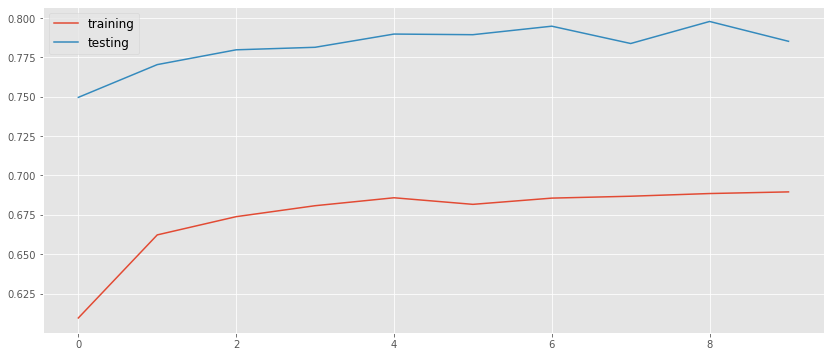

In [ ]:
plt.subplots(figsize=(14,6))
plt.plot(network_3.history['accuracy'],label='training')
plt.plot(network_3.history['val_accuracy'],label='testing')
plt.legend(loc='best',fontsize=12);

In [ ]:
y = np.concatenate([y for x, y in test_batches], axis=0)

In [ ]:
model_3_pred = np.argmax(model_3.predict(test_batches),axis=1)

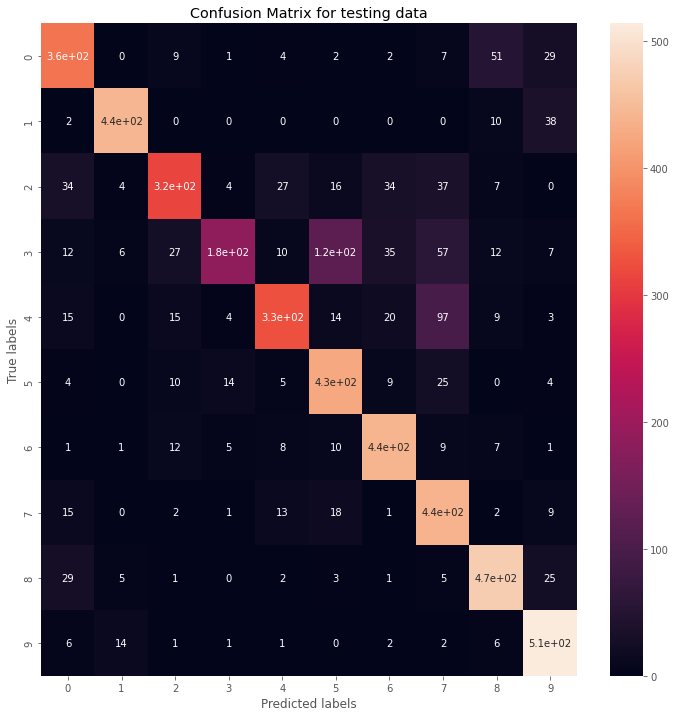

In [ ]:
plt.subplots(figsize=(12,12))
labels = [str(i) for i in range(0,10)]
cm = confusion_matrix(y, model_3_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for testing data')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels);

## Performs poorly